In [2]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
import math
import random
import numpy as np
from scipy.optimize import minimize

In [11]:
def generate_ansatz(noq, qc, angle):
    depth = noq
    off = 0
    for j in range(depth):
        for i in range(noq):
            qc.ry(angle[off + i], i)
            if (i != 0 and j != (depth - 1)):
                qc.cz(0,i)
        off += i+1

In [4]:
def had_test_b(qc, ancilla_index, gate, noq, angle, b):
    qc.h(ancilla_index)
    generate_ansatz(noq, qc, angle)
    append_A_matrix(qc, gate, ancilla_index)
    generate_B(noq, qc, b)
    qc.h(ancilla_index)

In [5]:
def append_A_matrix(qc, gate, ancilla, start = 0, end = 0):
    if (end == 0):
        end = len(gate)
    for i in range(start, end):
        if (gate[i - start] == 1):
            qc.cx(ancilla, i)
        if (gate[i - start] == 2):
            qc.cy(ancilla, i)   
        if (gate[i - start] == 3):
            qc.cz(ancilla, i)             

In [6]:
def generate_B(noq, qc, b):
    qc.initialize(b, range(noq))

In [7]:
def had_test_a(qc, ancilla_index, gat, gat_trans, noq, angle, bIm = False):
    qc.h(ancilla_index)
    if (bIm):
        qc.sdg(ancilla_index)
    generate_ansatz(noq, qc, angle)
    append_A_matrix(qc, gat, ancilla_index)
    append_A_matrix(qc, gat_trans, ancilla_index)
    qc.h(ancilla_index)

In [8]:
def generate_control_ansatz(noq, qc, angle, ancilla):
    depth = noq
    off = 0
    for j in range(depth):
        for i in range(noq):
            qc.cry(angle[off + i], i)
            if (i != 0 and j != (depth - 1)):
                qc.ccz(ancilla,0,i)
        off += i+1

In [9]:
import numpy as np
I = np.asmatrix('1 0;0 1')
X = np.asmatrix('0 1;1 0')
Y = np.asmatrix('0 0-1j;0+1j 0')
Z = np.asmatrix('1 0;0 -1')
pauli_i = [I, 0]
pauli_x = [X, 1]
pauli_y = [Y, 2]
pauli_z = [Z, 3]

def get_basis_set(num_of_qubit = 1):
    basis_set = [pauli_i, pauli_x, pauli_y, pauli_z]
    int_set = [pauli_i, pauli_x, pauli_y, pauli_z]
    temp_set = []
    for i in range (num_of_qubit-1):
        for j in range (len(basis_set)):
            for k in range (len(int_set)):
                a = basis_set[j]
                b = int_set[k]
                #temp_set.append()
                temp_set.append([np.kron(a[0],b[0]),[a[1],b[1]]])
        int_set = temp_set
        #print(int_set)
        temp_set = []
    return int_set

def get_decomposition(A, num_of_q):
    basis = get_basis_set(num_of_q)
    dec_list = []
    for i in range(len(basis)):
        b = basis[i]
        coeff = np.trace(A*b[0])/(2**num_of_q)
        dec_list.append([coeff, b[1]])
    return dec_list
def get_arbitary_decomposition(A):
    size = A.shape
    size = size[0]
    power = math.log2(size)
    p = int(power)
    if (p != power):
        p += 1
    ret = np.zeros([2**p,2**p], dtype = float)
    ret[:size, :size] = A
    for i in range(size, 2**p):
        ret[i,i] = 1
    return get_decomposition(ret, p)

In [10]:
noq = 2

angle = [np.pi/2, np.pi/8, np.pi/6, np.pi/3]
a = np.matrix('1 2 3 5; 5 4 3 1; 1 3 3 1; 2 3 4 7')
b = [0.7071067, 0.7071067, 0.7071067, 0.7071067]
a = a/np.linalg.norm(b)
b = b/np.linalg.norm(b)
dec_list = get_arbitary_decomposition(a)
gate = []
coeff = []
for i in range(len(dec_list)):
    if (abs(dec_list[i][0]) != 0):
        coeff.append(dec_list[i][0])
        gate.append(dec_list[i][1])

denom = 0
numer = 0
cof = 0
backend = Aer.get_backend('statevector_simulator')
for i in range(len(coeff)):
    for j in range(len(coeff)):
        circ = QuantumCircuit(noq + 1,1)
        cof = coeff[i]*coeff[j]
        had_test_a(circ, noq, gate[i], gate[j], noq, angle)
        circ.measure(noq, 0)
        job = execute(circ, backend)
        result = job.result()
        outputstate = result.get_statevector(circ, decimals=100)
        o = outputstate
        m_sum = 0
        for l in range (0, len(o)):
            if (l%2 == 1):
                n = float(o[l])**2
                m_sum+=n
        denom += cof*m_sum

for i in range(len(coeff)):
    circ = QuantumCircuit(noq + 1,1)
    had_test_b(circ, noq, gate[i], noq, angle, b)
    circ.measure(noq, 0)
    job = execute(circ, backend)
    result = job.result()
    outputstate = result.get_statevector(circ, decimals=100)
    o = outputstate
    m_sum = 0
    for l in range (0, len(o)):
        if (l%2 == 1):
            n = float(o[l])**2
            m_sum+=n
    numer += coeff[i]*m_sum
    
numer *= numer 
print(1-(numer/denom))

c:\users\hrush\.conda\envs\quantum_computing\lib\site-packages\ipykernel_launcher.py:33: ComplexWarning: Casting complex values to real discards the imaginary part
c:\users\hrush\.conda\envs\quantum_computing\lib\site-packages\ipykernel_launcher.py:48: ComplexWarning: Casting complex values to real discards the imaginary part


(0.5948771101767536-0.05079473673838807j)


In [11]:
a = np.matrix('1 2 3 4; 2 5 1 3; 3 1 6 2; 4 3 2 7')
b = [0.7071067, 0.7071067, 0.7071067, 0.7071067]
d = np.linalg.norm(b)
a = a/(d*np.linalg.norm(a))
b = b/d
print(np.linalg.norm(b), np.linalg.norm(a))
dec_list = get_arbitary_decomposition(a)
gate = []
coeff = []
for i in range(len(dec_list)):
    if (abs(dec_list[i][0]) != 0):
        coeff.append(dec_list[i][0])
        gate.append(dec_list[i][1])
print(coeff)
print(len(coeff))
def calculate_cost(angle):  
    denom = 0
    numer = 0
    cof = 0
    backend = Aer.get_backend('statevector_simulator')
    for i in range(len(coeff)):
        for k in range(len(coeff)):
            circ = QuantumCircuit(noq + 1,1)
            cof = coeff[i]*coeff[k]
            had_test_a(circ, noq, gate[i], gate[k], noq, angle)
            circ.measure(noq, 0)
            job = execute(circ, backend)
            result = job.result()
            outputstate = result.get_statevector(circ, decimals=100)
            o = outputstate
            m_sum = 0
            for l in range (0, len(o)):
                if (l%2 == 1):
                    n = float(o[l])**2
                    m_sum+=n
            denom += cof*m_sum
            '''circ = QuantumCircuit(noq + 1,1)
            had_test_a(circ, noq, gate[i], gate[k], noq, angle, True)
            circ.measure(noq, 0)
            job = execute(circ, backend)
            result = job.result()
            outputstate = result.get_statevector(circ, decimals=100)
            o = outputstate
            m_sum = 0
            for l in range (0, len(o)):
                if (l%2 == 1):
                    n = float(o[l])**2
                    m_sum+=n
            denom += j*cof*m_sum'''
    
    for i in range(len(coeff)):
        for k in range(len(coeff)):
            qc = QuantumCircuit(2*noq + 1, 1)
            Hadamard_Overlap_Test(qc ,noq, b, angle, gate[i], gate[k])
            job = execute(qc, backend)
            result = job.result()
            outputstate = result.get_statevector(qc, decimals=100)
            o = outputstate
            m_sum = 0
            for l in range (0, len(o)):
                if (l%2 == 1):
                    n = float(o[l])**2
                    m_sum+=n
            numer += coeff[i]*coeff[k]*m_sum
            '''qc = QuantumCircuit(2*noq + 1, 1)
            Hadamard_Overlap_Test(qc ,noq, b, angle, gate[i], gate[k], True)
            job = execute(qc, backend)
            result = job.result()
            outputstate = result.get_statevector(qc, decimals=100)
            o = outputstate
            m_sum = 0
            for l in range (0, len(o)):
                if (l%2 == 1):
                    n = float(o[l])**2
                    m_sum+=n
            numer += j*coeff[i]*coeff[k]*m_sum'''
            #print(j*coeff[i]*coeff[k]*m_sum)
    print("cost = "+str(1-(numer/denom)))
    
    return abs(1-(numer/denom))  

1.0 0.7071068623731044
[0.23930157035887994, 0.10075855594058103, -0.06297409746286314, 0.15113783391087154, 0.1259481949257263, (-0.07556891695543577+0j), -0.0881637364480084, -0.037784458477717886]
8


In [12]:
angle = [0.45649234, 2.04159974, 1.5707963 , 1.57079648]
maxiter = 2000000
iters = 0 
threshold = 0.0047
k=0
out = minimize(calculate_cost, x0=angle, method="cobyla", options={'maxiter':2000}, tol = threshold)
print(out)

c:\users\hrush\.conda\envs\quantum_computing\lib\site-packages\ipykernel_launcher.py:34: ComplexWarning: Casting complex values to real discards the imaginary part


NameError: name 'Hadamard_Overlap_Test' is not defined

In [13]:
a = np.matrix('1 2 3 4; 2 5 1 3; 3 1 6 2; 4 3 2 7')
a = a/np.linalg.norm(a)
print(np.linalg.norm(a))
b = np.matrix('0.7071067;0.7071067;0.7071067;0.7071067')
b = b/np.linalg.norm(b)
ans = np.linalg.inv(a)*b
print((ans))#/np.linalg.norm(ans))

1.0
[[-0.53983342]
 [ 1.07966683]
 [ 1.07966683]
 [ 0.53983342]]


In [14]:
def Hadamard_Overlap_Test(qc ,noq, b, angle, gate, gate_trans,bIm = False):
    qc.h(2*noq)
    generate_ansatz(noq, qc, angle)
    append_A_matrix(qc, gate, 2*noq, 0, noq)
    qc.initialize(b, range(noq, 2*noq))
    append_A_matrix(qc, gate_trans, 2*noq, noq, 2*noq)
    qc.barrier()
    for i in range(0, noq):
        qc.cx(i, noq+i)
    qc.h(2*noq)
    if (bIm):
        qc.rz(np.pi/2, 2*noq)
    qc.measure(2*noq, 0)
    

In [15]:
print(range(2))

range(0, 2)


[-0.316+0.j -0.005+0.j  0.707+0.j  0.632+0.j]


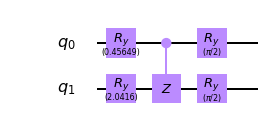

In [13]:
circ = QuantumCircuit(2)
generate_ansatz(2, circ, [0.45649234, 2.04159974, 1.5707963 , 1.57079648])
circ.draw(output="mpl")
backend = Aer.get_backend('statevector_simulator')
job = execute(circ, backend)
result = job.result()
outputstate = result.get_statevector(circ, decimals=3)
print(outputstate)
circ.draw(output="mpl")